## Generate Result Tables
- MCHAD
- CAC
- II
- Center Loss
- G-MCHAD
- G-Center
- G-CAC

In [1]:
import seaborn as sb
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import pandas as pd
from os.path import join

In [2]:
sb.set()
sb.set_style("whitegrid")
sb.set_context("paper")

In [3]:
# root folder for experiment run
root = "/run/media/ki/292b6fa6-3ffb-4b84-9ed3-6bf879e10535/kirchhei/newmchad/aggregated/"

In [4]:
# map test cases
dataset_map = {
    "test_vs_uniformnoise": "Gauss",
    "test_vs_gaussiannoise": "Uniform",
    "test_vs_tinycrop": "Tiny Crop",
    "test_vs_tinyresize": "Tiny Resize",
    "test_vs_lsuncrop": "LSUN Crop",
    "test_vs_lsunresize": "LSUN Resize",
    "test_vs_textures": "Texture",
}

model_map = {
    "src.models.CAC": "CAC",
    "src.models.Softmax": "Softmax",
    "src.models.MCHAD": "MCHAD",
    "src.models.Center": "Center",
    "src.models.II": "II",
    "src.models.GCAC": "G-CAC",
    "src.models.GCenter": "G-Center",
}


train_dataset_map = {
    "src.datamodules.CIFAR10DataModule": "CIFAR10",
    "src.datamodules.SVHNDataModule": "SVHN",
    "src.datamodules.CIFAR100DataModule": "CIFAR100",
}

In [5]:
def convert(df, key="Distance", task="OSR"):
    """
    Get correct metrics from dataframe
    """
    df.rename(
        inplace=True,
        columns={
            "Accuracy/test": "Accuracy",
            f"{key}/{task}/AUROC/test": "AUROC",
            f"{key}/{task}/AUPR-IN/test": "AUPR-IN",
            f"{key}/{task}/AUPR-OUT/test": "AUPR-OUT",
            f"{key}/{task}/FPR@95TPR/test": "FPR95",
        },
    )

    return df

In [6]:
directories = []
directories += [f"./svhn/center/{i}" for i in range(21)]
directories += [f"./svhn/mchad/{i}" for i in range(21)]
directories += [f"./svhn/gmchad/{i}" for i in range(21)]
directories += [f"./svhn/gcenter/{i}" for i in range(21)]
directories += [f"./svhn/gcac/{i}" for i in range(21)]
directories += [f"./svhn/cac/{i}" for i in range(21)]
directories += [f"./svhn/ii/{i}" for i in range(21)]

directories += [f"./cifar100/mchad/{i}" for i in range(21)]
directories += [f"./cifar100/gmchad/{i}" for i in range(21)]
directories += [f"./cifar100/gcenter/{i}" for i in range(21)]
directories += [f"./cifar100/gcac/{i}" for i in range(21)]
directories += [f"./cifar100/cac/{i}" for i in range(21)]
directories += [f"./cifar100/ii/{i}" for i in range(21)]
# directories += [f"./cifar100/center/{i}" for i in range(21)]


del directories[directories.index("./cifar100/cac/13")]

directories += [f"./cifar10/mchad/{i}" for i in range(21)]
directories += [f"./cifar10/center/{i}" for i in range(21)]
directories += [f"./cifar10/gmchad/{i}" for i in range(21)]
directories += [f"./cifar10/gcenter/{i}" for i in range(21)]
directories += [f"./cifar10/gcac/{i}" for i in range(21)]
directories += [f"./cifar10/cac/{i}" for i in range(21)]
directories += [f"./cifar10/ii/{i}" for i in range(21)]

In [7]:


def get_training_set(datamodule):
    target = datamodule["_target_"]
    d = train_dataset_map.get(target)

    if not d:
        if target == "src.datamodules.MultiDatamodule":
            d = train_dataset_map.get(datamodule["module1"]["_target_"])

    if not d:
        print(datamodule)
    else:
        print(d)

    return d


def load(path):
    local_df = []

    df = pd.read_csv(join(path, "results.csv"))
    metrics = pd.read_csv(join(path, "csv/version_0/metrics.csv"))
    config = OmegaConf.load(join(path, "tb/version_0/hparams.yaml"))
    df["Dataset"] = get_training_set(config["datamodule"])
    df["Outliers"] = df["test_case_name"].apply(dataset_map.get)
    model = str(config["model"]["_target_"])

    if model == "src.models.CAC":
        df["Model"] = "CAC"
        df = convert(df, "Distance")
    elif model == "src.models.SoftMax":
        print("EB-OOD")
        df_ebm = df.copy(deep=True)
        df_ebm["Model"] = "EB-OOD"
        df_emb = convert(df_ebm, "EnergyBased")

        local_df.append(df_ebm)

        print("Softmax")
        df["Model"] = "Softmax"
        df = convert(df, "Softmax")

    elif model == "src.models.MCHAD":
        if config["model"]["weight_oe"] == 0.0:
            # print(f"Weight OE: {config['model']['weight_oe']}")
            df["Model"] = "MCHAD"
        else:
            print(f"Weight OE: {config['model']['weight_oe']}")
            df["Model"] = "G-MCHAD"

        df = convert(df)
    elif model == "src.models.Center":
        df["Model"] = "Center"
        df = convert(df, "Softmax")
    elif model == "src.models.IIModel":
        df["Model"] = "II"
        df = convert(df)
    elif model == "src.models.GCenter":
        df["Model"] = "G-Center"
        df = convert(df, key="Softmax")
    elif model == "src.models.GCAC":
        df["Model"] = "G-CAC"
        df = convert(df, key="Distance")
    else:
        raise Exception(f"UNKNOWN: {model}")

    local_df.append(df)
    return config, pd.concat(local_df), metrics

In [8]:
dfs = []

for d in directories:
    # filter(lambda x: "center" not in x and "cifar100/softmax/" not in x and "mchad-o" not in x, directories):
    path = join(root, d)
    config, df, metrics = load(path)
    try:
        if df is not None:
            print(path)
            print(
                f"{df['Dataset'][0]}/{df['Model'][0]} -> {df['AUROC'].mean()} {len(df)}"
            )
            df = df[
                [
                    "Accuracy",
                    "AUROC",
                    "AUPR-IN",
                    "AUPR-OUT",
                    "FPR95",
                    "Dataset",
                    "Outliers",
                    "Model",
                ]
            ]
            dfs.append(df.copy())
    except Exception as e:
        print("EXCEPTION WHILE LOADING")
        print(type(e), e)
        print(df.columns)

df = pd.concat(dfs)

SVHN
/run/media/ki/292b6fa6-3ffb-4b84-9ed3-6bf879e10535/kirchhei/newmchad/aggregated/./svhn/center/0
SVHN/Center -> 0.976376610142844 8
SVHN
/run/media/ki/292b6fa6-3ffb-4b84-9ed3-6bf879e10535/kirchhei/newmchad/aggregated/./svhn/center/1
SVHN/Center -> 0.9775118912969317 8
SVHN
/run/media/ki/292b6fa6-3ffb-4b84-9ed3-6bf879e10535/kirchhei/newmchad/aggregated/./svhn/center/2
SVHN/Center -> 0.9766599025045123 8
SVHN
/run/media/ki/292b6fa6-3ffb-4b84-9ed3-6bf879e10535/kirchhei/newmchad/aggregated/./svhn/center/3
SVHN/Center -> 0.9784341965402875 8
SVHN
/run/media/ki/292b6fa6-3ffb-4b84-9ed3-6bf879e10535/kirchhei/newmchad/aggregated/./svhn/center/4
SVHN/Center -> 0.9810961144311088 8
SVHN
/run/media/ki/292b6fa6-3ffb-4b84-9ed3-6bf879e10535/kirchhei/newmchad/aggregated/./svhn/center/5
SVHN/Center -> 0.9741806047303336 8
SVHN
/run/media/ki/292b6fa6-3ffb-4b84-9ed3-6bf879e10535/kirchhei/newmchad/aggregated/./svhn/center/6
SVHN/Center -> 0.9706423112324306 8
SVHN
/run/media/ki/292b6fa6-3ffb-4b84-9ed3

In [9]:
df["AUROC"] = df["AUROC"].apply(lambda x: x * 100)
df["AUPR-IN"] = df["AUPR-IN"].apply(lambda x: x * 100)
df["AUPR-OUT"] = df["AUPR-OUT"].apply(lambda x: x * 100)
df["FPR95"] = df["FPR95"].apply(lambda x: x * 100)
df["Accuracy"] = df["Accuracy"].apply(lambda x: x * 100)

In [10]:
df = df.set_index(["Dataset", "Outliers", "Model"]).dropna()

df

Accuracy      AUROC    AUPR-IN   AUPR-OUT  \
Dataset Outliers    Model                                                
SVHN    Texture     Center  94.994622  95.967543  98.974085  85.685676   
        Gauss       Center  94.994622  99.509495  99.821031  98.646486   
        Uniform     Center  94.994622  99.957824  99.986303  99.823630   
        Tiny Crop   Center  94.994622  97.462404  99.066621  93.270266   
        Tiny Resize Center  94.994622  96.430039  98.635793  90.653467   
...                               ...        ...        ...        ...   
CIFAR10 Uniform     II      51.450002  20.546530  37.369168  34.570593   
        Tiny Crop   II      51.450002  38.636118  43.354911  41.314924   
        Tiny Resize II      51.450002  43.564519  47.122183  43.843582   
        LSUN Crop   II      51.450002  41.920763  45.817283  43.308711   
        LSUN Resize II      51.450002  45.058864  48.180142  44.386017   

                                 FPR95  
Dataset Outliers    Model               
SVHN    Texture     Center   23.918439  
        Gauss       Center    1.740000  
        Uniform     Center    0.000000  
        Tiny Crop   Center   17.280000  
        Tiny Resize Center   23.970000  
...                                ...  
CIFAR10 Uniform     II      100.000000  
        Tiny Crop   II       99.250001  
        Tiny Resize II       98.589998  
        LSUN Crop   II       98.490000  
        LSUN Resize II       99.080002  

[2933 rows x 5 columns]

In [11]:
from itertools import product
datasets = ["SVHN", "CIFAR10", "CIFAR100"]
# models = ["CAC", "II", "Center", "Softmax", "EB-OOD", "MCHAD", "G-MCHAD"]
models = ["MCHAD", "II", "CAC", "Center", "G-MCHAD", "G-Center", "G-CAC"]

t =  df.reset_index().groupby(by=["Dataset", "Model"]).agg(
        {
            "Accuracy": ["mean", "sem"],
            "AUROC": ["mean", "sem"],
            "AUPR-IN": ["mean", "sem"],
            "AUPR-OUT": ["mean", "sem"],
            "FPR95": ["mean", "sem"],
        }
    ).reindex(list(product(datasets, models)))

s = t.to_latex(
        float_format="%.2f",
        multirow=True,
        escape=False,
        label="tab:results",
        # bold_rows="True",
    )

repl = {
    "mean": "Mean",
    "sem": "$\\pm \sigma_{\\bar{x}}$",
    " MCHAD": " \\textbf{MCHAD (ours)}",
    "G-MCHAD": "\\textbf{G-MCHAD (ours)}",
    "G-Center": "\\textbf{G-Center (ours)}",
    "G-CAC": "\\textbf{G-CAC (ours)}",
}

for k, v in repl.items():
    s = s.replace(k, v)

print(s)

\begin{table}
\centering
\label{tab:results}
\begin{tabular}{llrrrrrrrrrr}
\toprule
         &       & \multicolumn{2}{l}{Accuracy} & \multicolumn{2}{l}{AUROC} & \multicolumn{2}{l}{AUPR-IN} & \multicolumn{2}{l}{AUPR-OUT} & \multicolumn{2}{l}{FPR95} \\
         &       &     Mean &  $\pm \sigma_{\bar{x}}$ &  Mean &  $\pm \sigma_{\bar{x}}$ &    Mean &  $\pm \sigma_{\bar{x}}$ &     Mean &  $\pm \sigma_{\bar{x}}$ &  Mean &  $\pm \sigma_{\bar{x}}$ \\
Dataset & Model &          &      &       &      &         &      &          &      &       &      \\
\midrule
\multirow{7}{*}{SVHN} & \textbf{MCHAD (ours)} &    96.69 & 0.01 & 97.49 & 0.06 &   99.10 & 0.03 &    91.22 & 0.23 & 12.50 & 0.43 \\
         & II &    16.33 & 0.64 & 50.96 & 1.48 &   74.92 & 0.92 &    30.83 & 1.27 & 90.98 & 1.25 \\
         & CAC &    96.69 & 0.01 & 91.10 & 0.26 &   92.45 & 0.26 &    84.18 & 0.38 & 19.66 & 0.54 \\
         & Center &    94.93 & 0.02 & 97.54 & 0.10 &   99.13 & 0.04 &    92.78 & 0.34 & 15.34 & 0.71 \\
  

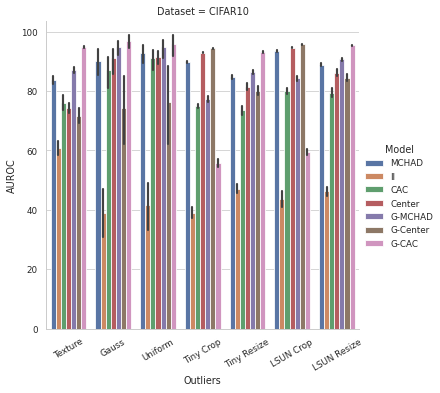

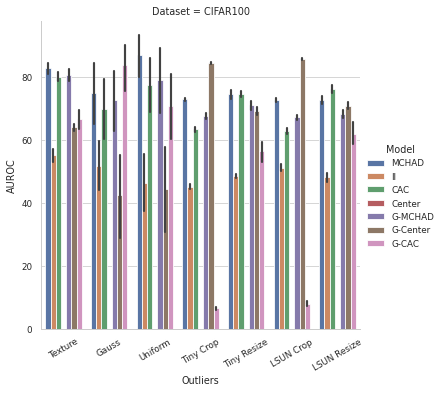

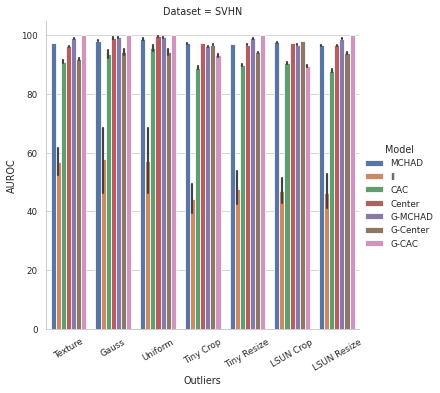

In [12]:
methods = ["MCHAD", "II", "CAC", "Center", "G-MCHAD", "G-Center", "G-CAC"]

for dataset in ["CIFAR10", "CIFAR100", "SVHN"]:
    g = sb.catplot(
        data=df.reset_index()[df.reset_index()["Dataset"] == dataset],
        x="Outliers",
        y="AUROC",
        kind="bar",
        hue="Model",
        col="Dataset",
        hue_order=methods
    )
    g.set_xticklabels(rotation=30)
    plt.savefig(f"out/single-auroc-{dataset}.png", dpi=300)
    plt.show()

In [13]:
tmp = df.reset_index().copy()
# tmp = tmp[(tmp["Model"] == "MCHAD") | (tmp["Model"] == "G-MCHAD")| (tmp["Model"] == "G-CAC") | (tmp["Model"] == "G-Center")]

print(
    tmp
    .groupby(by=["Dataset", "Model"])
    .agg(
        {
            "Accuracy": ["mean", "std"],
            "AUROC": ["mean", "std"],
            "AUPR-IN": ["mean", "std"],
            "AUPR-OUT": ["mean", "std"],
            "FPR95": ["mean", "std"],
        }
    )
    .to_html(
        float_format="%.2f",
        escape=False,
    )
)


<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th></th>
      <th colspan="2" halign="left">Accuracy</th>
      <th colspan="2" halign="left">AUROC</th>
      <th colspan="2" halign="left">AUPR-IN</th>
      <th colspan="2" halign="left">AUPR-OUT</th>
      <th colspan="2" halign="left">FPR95</th>
    </tr>
    <tr>
      <th></th>
      <th></th>
      <th>mean</th>
      <th>std</th>
      <th>mean</th>
      <th>std</th>
      <th>mean</th>
      <th>std</th>
      <th>mean</th>
      <th>std</th>
      <th>mean</th>
      <th>std</th>
    </tr>
    <tr>
      <th>Dataset</th>
      <th>Model</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th rowspan="7" valign="top">CIFAR10</th>
      <th>CAC</th>
      <td>93.55</td>
      <td>0.14</td>
      <td>80.35</td>
      <td>8.75</td>
      <td>7

In [14]:
from scipy.stats import ttest_ind

tmp = df.reset_index().copy()
# tmp = tmp[(tmp["Model"] == "MCHAD") | (tmp["Model"] == "G-MCHAD")]

for metric in ["Accuracy", "AUROC", "AUPR-IN", "AUPR-OUT", "FPR95"]:
    for dataset in ["SVHN", "CIFAR10", "CIFAR100"]:
        a = tmp[(tmp["Model"] == "CAC") & (tmp["Dataset"] == dataset)][metric]
        b = tmp[(tmp["Model"] == "MCHAD") & (tmp["Dataset"]== dataset)][metric]
        stat, p = ttest_ind(a,b, equal_var=False)
        print(f"{metric} {dataset} -> {p < 0.05} ")

Accuracy SVHN -> False 
Accuracy CIFAR10 -> True 
Accuracy CIFAR100 -> True 
AUROC SVHN -> True 
AUROC CIFAR10 -> True 
AUROC CIFAR100 -> True 
AUPR-IN SVHN -> True 
AUPR-IN CIFAR10 -> True 
AUPR-IN CIFAR100 -> True 
AUPR-OUT SVHN -> True 
AUPR-OUT CIFAR10 -> True 
AUPR-OUT CIFAR100 -> False 
FPR95 SVHN -> True 
FPR95 CIFAR10 -> True 
FPR95 CIFAR100 -> False 
